# Fase 1: Exploración y Prototipado

**Objetivo:** Cargar datos, realizar EDA, limpiar y probar modelos base.

## 1. Carga de Datos

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Configuración de visualización
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Buscar el archivo CSV
data_path = '../Data/Air_Traffic_Passenger_Statistics.csv'
if not os.path.exists(data_path):
    # Intentar buscar recursivamente si la ruta no es exacta
    for root, dirs, files in os.walk('..'):
        if 'Air_Traffic_Passenger_Statistics.csv' in files:
            data_path = os.path.join(root, 'Air_Traffic_Passenger_Statistics.csv')
            break

print(f"Cargando datos desde: {data_path}")
df = pd.read_csv(data_path)
df.head()

Cargando datos desde: ../Data/Air_Traffic_Passenger_Statistics.csv


,ActivityPeriod,OperatingAirline,OperatingAirlineIATACode,PublishedAirline,PublishedAirlineIATACode,GEOSummary,GEORegion,ActivityTypeCode,PriceCategoryCode,Terminal,BoardingArea,PassengerCount,AdjustedActivityTypeCode,AdjustedPassengerCount,Year,Month
0,200507,ATA Airlines,TZ,ATA Airlines,TZ,Domestic,US,Deplaned,Low Fare,Terminal 1,B,27271.0,Deplaned,27271.0,2005.0,July
1,200507,ATA Airlines,TZ,ATA Airlines,TZ,Domestic,US,Enplaned,Low Fare,Terminal 1,B,29131.0,Enplaned,29131.0,2005.0,July
2,200507,ATA Airlines,TZ,ATA Airlines,TZ,Domestic,US,Thru / Transit,Low Fare,Terminal 1,B,5415.0,Thru / Transit * 2,10830.0,2005.0,July
3,200507,Air Canada,AC,Air Canada,AC,International,Canada,Deplaned,Other,Terminal 1,B,35156.0,Deplaned,35156.0,2005.0,July
4,200507,Air Canada,AC,Air Canada,AC,International,Canada,Enplaned,Other,Terminal 1,B,34090.0,Enplaned,34090.0,2005.0,July


## 2. Análisis Exploratorio (EDA)

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15007 entries, 0 to 15006
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ActivityPeriod            15007 non-null  object 
 1   OperatingAirline          14991 non-null  object 
 2   OperatingAirlineIATACode  14937 non-null  object 
 3   PublishedAirline          14991 non-null  object 
 4   PublishedAirlineIATACode  14937 non-null  object 
 5   GEOSummary                14991 non-null  object 
 6   GEORegion                 14991 non-null  object 
 7   ActivityTypeCode          14991 non-null  object 
 8   PriceCategoryCode         14991 non-null  object 
 9   Terminal                  14991 non-null  object 
 10  BoardingArea              14991 non-null  object 
 11  PassengerCount            14991 non-null  float64
 12  AdjustedActivityTypeCode  14991 non-null  object 
 13  AdjustedPassengerCount    14991 non-null  float64
 14  Year  

In [3]:
# Chequear nulos
df.isnull().sum()

ActivityPeriod               0
OperatingAirline            16
OperatingAirlineIATACode    70
PublishedAirline            16
PublishedAirlineIATACode    70
GEOSummary                  16
GEORegion                   16
ActivityTypeCode            16
PriceCategoryCode           16
Terminal                    16
BoardingArea                16
PassengerCount              16
AdjustedActivityTypeCode    16
AdjustedPassengerCount      16
Year                        16
Month                       16
dtype: int64

In [4]:
# 1. Inspeccionar y eliminar las 16 filas vacías
print("Eliminando filas vacías...")
df_clean = df.dropna(subset=['OperatingAirline', 'PassengerCount']).copy()
print(f"Filas antes: {len(df)}, Filas después: {len(df_clean)}")

Eliminando filas vacías...
Filas antes: 15007, Filas después: 14991


In [5]:
# 2. Rellenar los códigos IATA faltantes con 'Unknown'
df_clean['OperatingAirlineIATACode'] = df_clean['OperatingAirlineIATACode'].fillna('Unknown')
df_clean['PublishedAirlineIATACode'] = df_clean['PublishedAirlineIATACode'].fillna('Unknown')

In [6]:
# 3. Verificar limpieza
print("\nNulos restantes:")
print(df_clean.isnull().sum())


Nulos restantes:
ActivityPeriod              0
OperatingAirline            0
OperatingAirlineIATACode    0
PublishedAirline            0
PublishedAirlineIATACode    0
GEOSummary                  0
GEORegion                   0
ActivityTypeCode            0
PriceCategoryCode           0
Terminal                    0
BoardingArea                0
PassengerCount              0
AdjustedActivityTypeCode    0
AdjustedPassengerCount      0
Year                        0
Month                       0
dtype: int64


## 3. Análisis de Series Temporales

Vamos a analizar la estacionalidad y tendencia de los datos.

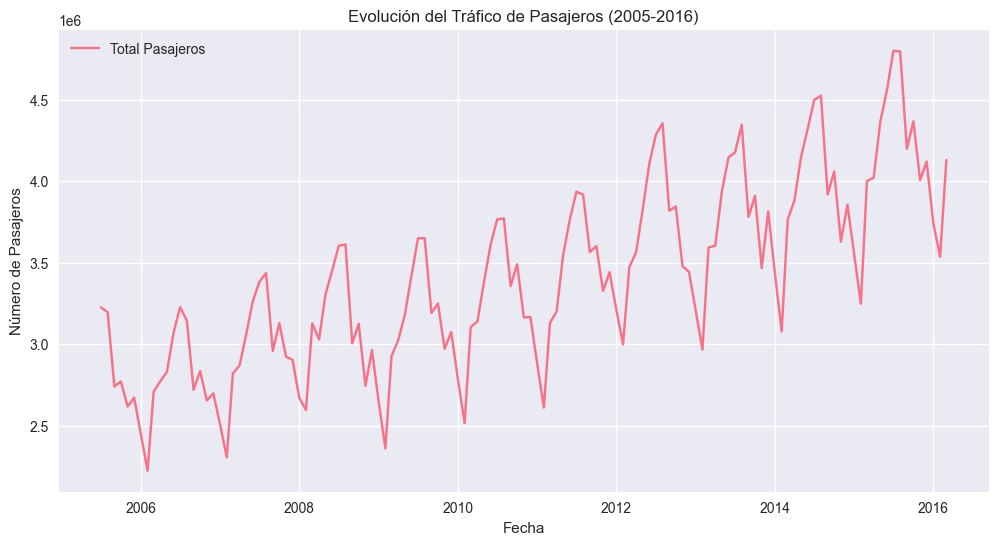

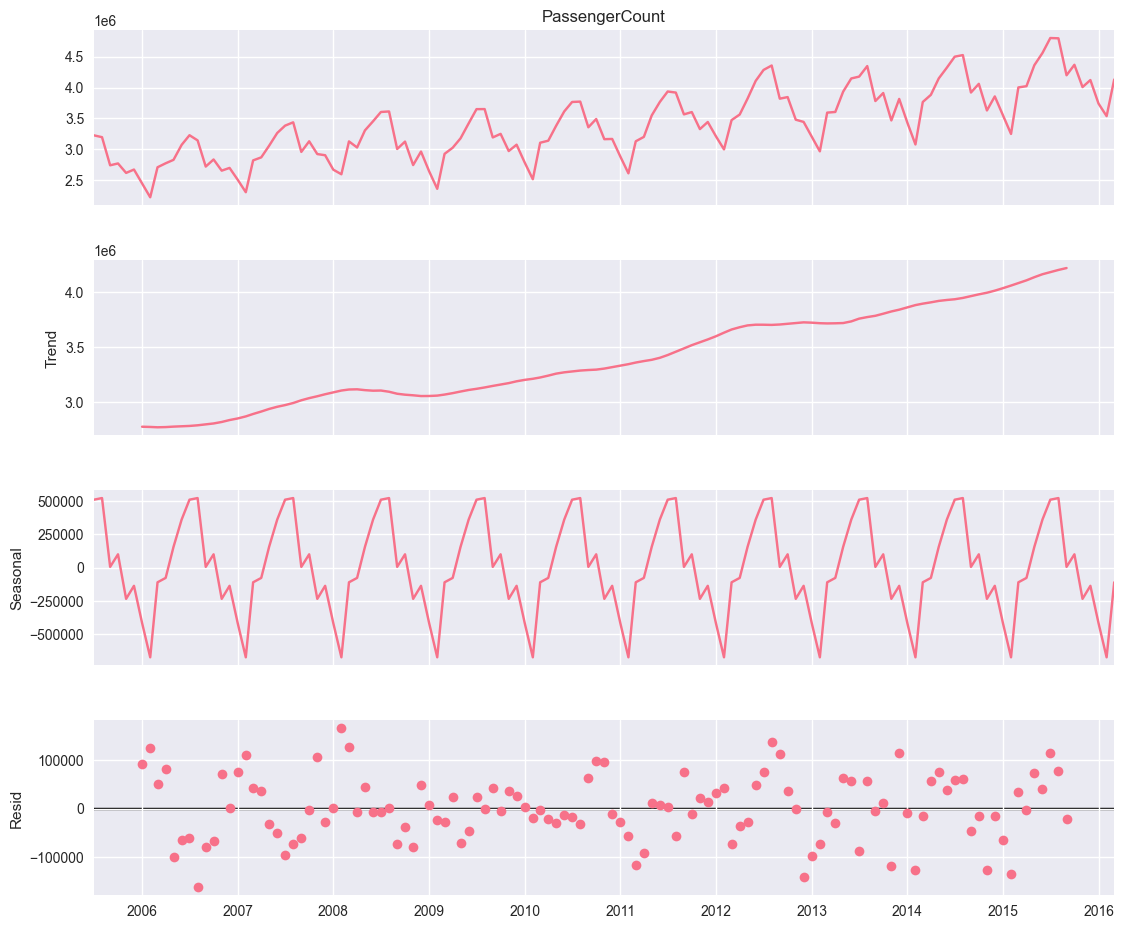

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose

# 1. Convertir ActivityPeriod a datetime (Formato YYYYMM)
df_clean['Date'] = pd.to_datetime(df_clean['ActivityPeriod'].astype(str), format='%Y%m')

# 2. Agrupar por fecha para tener el total de pasajeros por mes
monthly_passengers = df_clean.groupby('Date')['PassengerCount'].sum()

# 3. Plot de la serie temporal completa
plt.figure(figsize=(12, 6))
plt.plot(monthly_passengers, label='Total Pasajeros')
plt.title('Evolución del Tráfico de Pasajeros (2005-2016)')
plt.xlabel('Fecha')
plt.ylabel('Número de Pasajeros')
plt.legend()
plt.grid(True)
plt.show()

# 4. Descomposición Estacional (Tendencia + Estacionalidad + Residuo)
decomposition = seasonal_decompose(monthly_passengers, model='additive', period=12)

fig = decomposition.plot()
fig.set_size_inches(12, 10)
plt.show()

## 4. Análisis de Estacionariedad

Para aplicar modelos ARIMA, la serie debe ser estacionaria (media y varianza constantes).
Usaremos el **Test de Dickey-Fuller Aumentado (ADF)** y gráficos de autocorrelación.

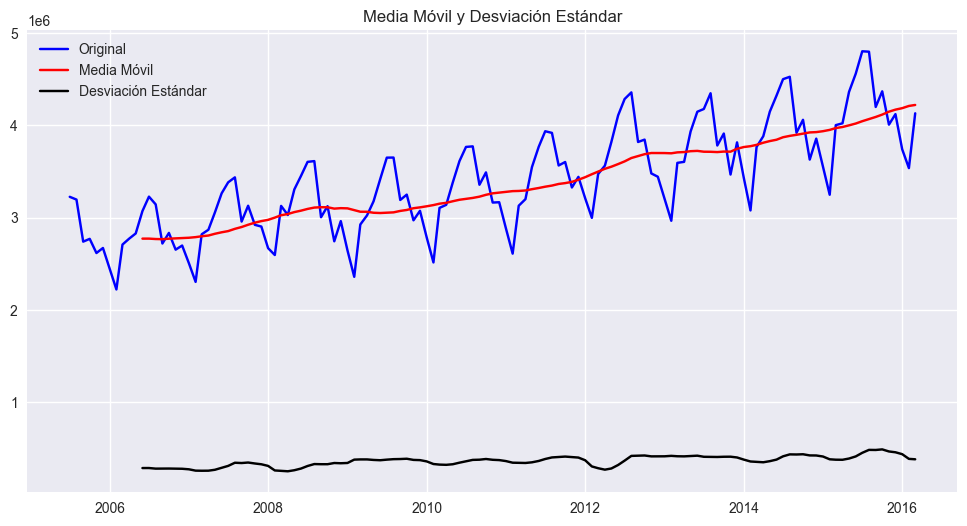

Resultados del Test de Dickey-Fuller:
Test Statistic                   0.206291
p-value                          0.972612
#Lags Used                      13.000000
Number of Observations Used    115.000000
Critical Value (1%)             -3.488535
Critical Value (5%)             -2.887020
Critical Value (10%)            -2.580360
dtype: float64


In [8]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def test_stationarity(timeseries):
    # Determinar estadísticas móviles
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    # Graficar estadísticas móviles
    plt.figure(figsize=(12, 6))
    plt.plot(timeseries, color='blue', label='Original')
    plt.plot(rolmean, color='red', label='Media Móvil')
    plt.plot(rolstd, color='black', label='Desviación Estándar')
    plt.legend(loc='best')
    plt.title('Media Móvil y Desviación Estándar')
    plt.show()

    # Realizar Test de Dickey-Fuller
    print('Resultados del Test de Dickey-Fuller:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

# Ejecutar test si monthly_passengers existe
if 'monthly_passengers' in locals():
    test_stationarity(monthly_passengers)
else:
    print("Advertencia: 'monthly_passengers' no encontrado. Asegúrate de haber ejecutado la celda de agrupación temporal.")


### Gráficos de Autocorrelación (ACF) y Autocorrelación Parcial (PACF)

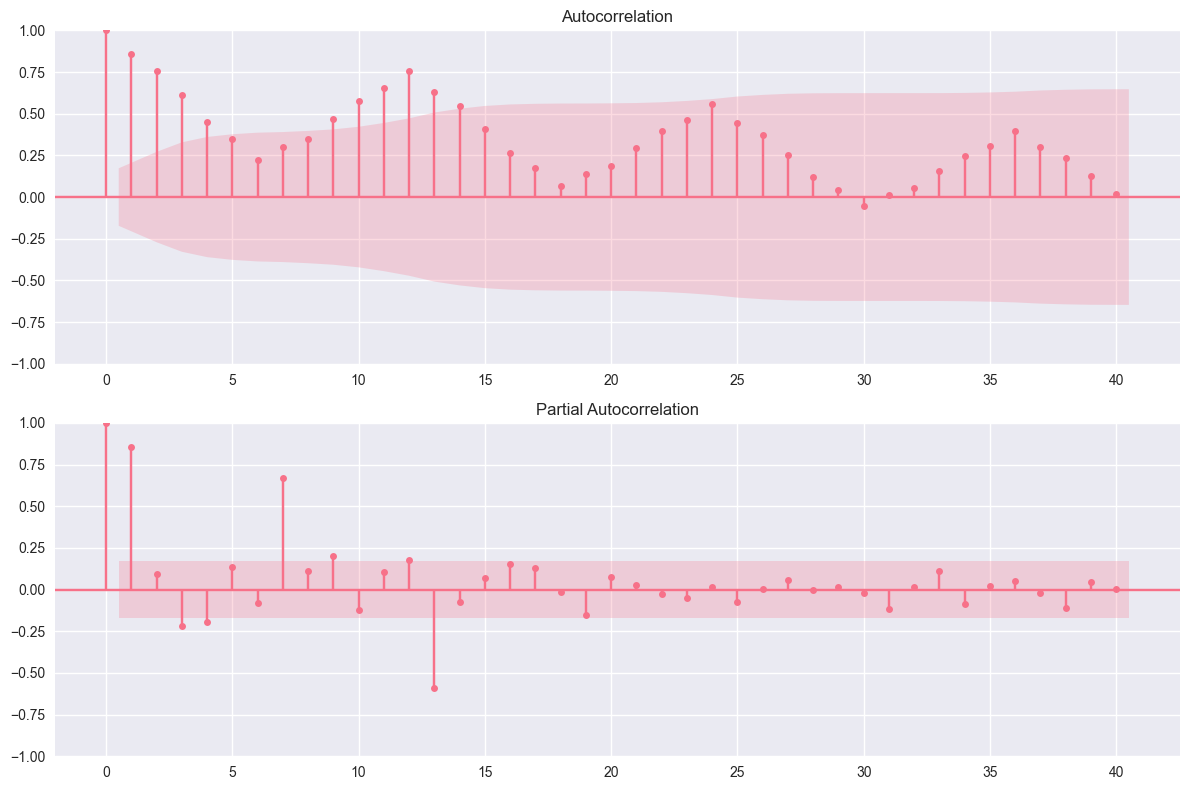

In [9]:
if 'monthly_passengers' in locals():
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    plot_acf(monthly_passengers, ax=ax1, lags=40)
    plot_pacf(monthly_passengers, ax=ax2, lags=40)
    plt.tight_layout()
    plt.show()

## 5. Modelado Base: ARIMA

Dado que la serie no es estacionaria (p-value > 0.05), aplicaremos diferenciación (d=1). Primero verificamos si la serie diferenciada es estacionaria.

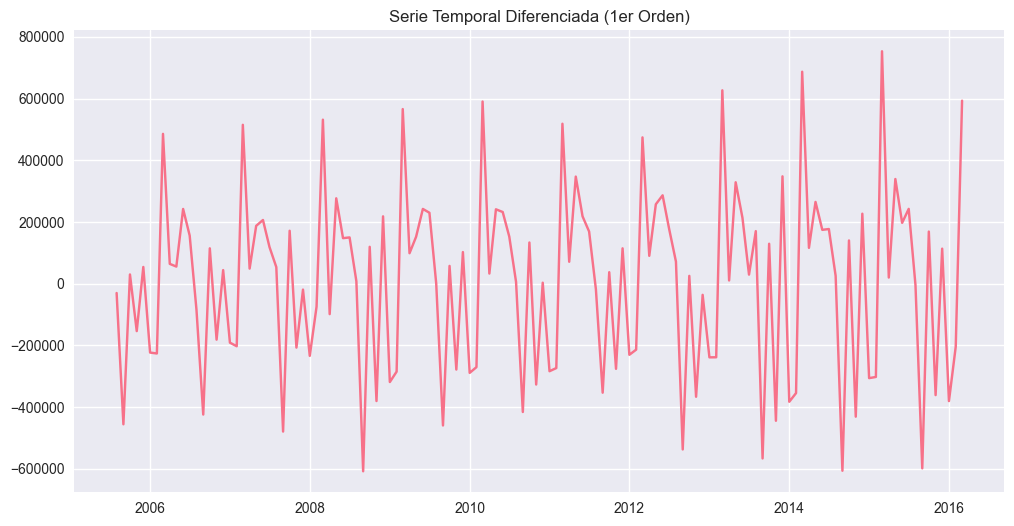

Resultados del Test de Dickey-Fuller para la serie diferenciada:


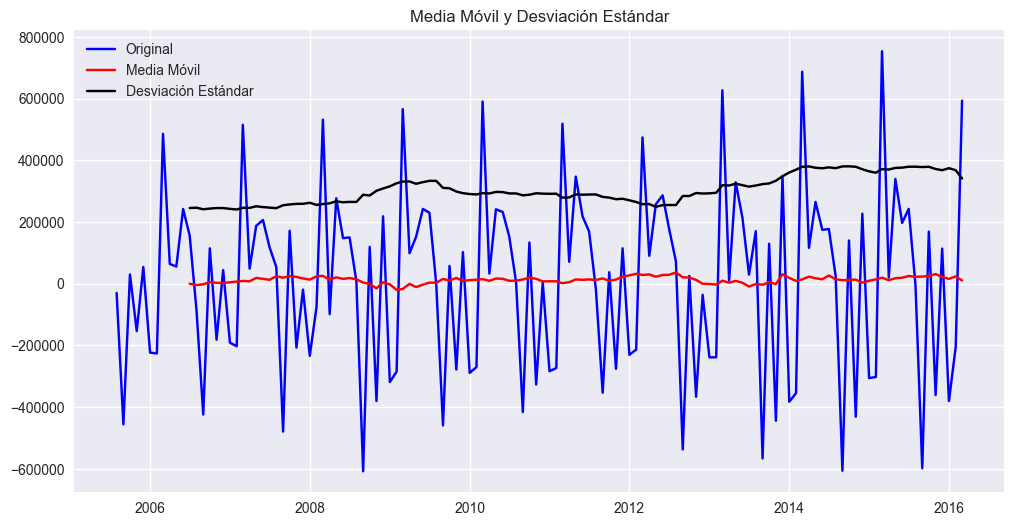

Resultados del Test de Dickey-Fuller:
Test Statistic                  -3.222081
p-value                          0.018742
#Lags Used                      12.000000
Number of Observations Used    115.000000
Critical Value (1%)             -3.488535
Critical Value (5%)             -2.887020
Critical Value (10%)            -2.580360
dtype: float64


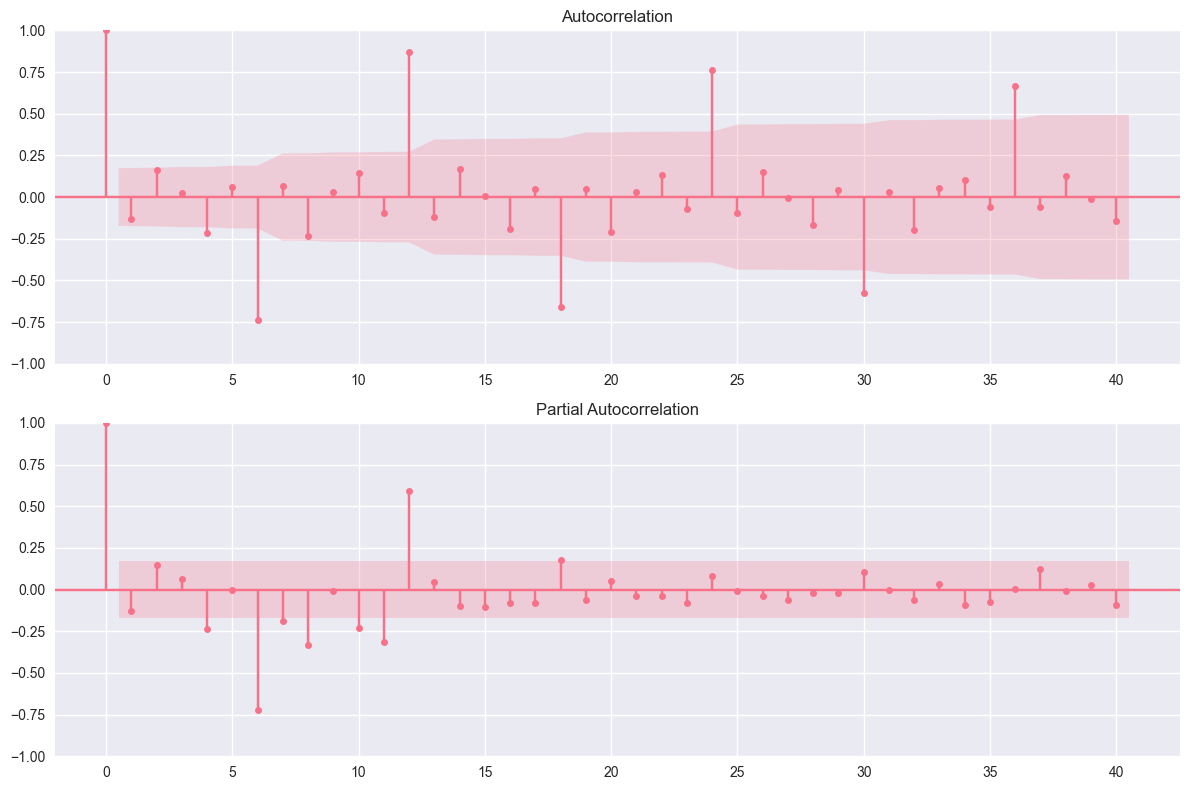

In [10]:
# Diferenciación
monthly_passengers_diff = monthly_passengers.diff().dropna()

# Graficar serie diferenciada
plt.figure(figsize=(12, 6))
plt.plot(monthly_passengers_diff)
plt.title('Serie Temporal Diferenciada (1er Orden)')
plt.show()

# Verificar estacionariedad de la serie diferenciada
print('Resultados del Test de Dickey-Fuller para la serie diferenciada:')
test_stationarity(monthly_passengers_diff)

# ACF y PACF de la serie diferenciada
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(monthly_passengers_diff, ax=ax1, lags=40)
plot_pacf(monthly_passengers_diff, ax=ax2, lags=40)
plt.tight_layout()
plt.show()

### Entrenamiento del Modelo ARIMA(1,1,1)

Probaremos un modelo base ARIMA(1,1,1). Statsmodels maneja la diferenciación internamente con el parámetro `d`.

In [11]:
from statsmodels.tsa.arima.model import ARIMA

# Ajustar modelo ARIMA(1,1,1)
model = ARIMA(monthly_passengers, order=(1, 1, 1))
model_fit = model.fit()

# Resumen del modelo
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:         PassengerCount   No. Observations:                  129
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1793.753
Date:                Fri, 28 Nov 2025   AIC                           3593.505
Time:                        23:03:42   BIC                           3602.062
Sample:                    07-01-2005   HQIC                          3596.982
                         - 03-01-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1340      0.642     -0.209      0.835      -1.393       1.124
ma.L1          0.0621      0.643      0.097      0.923      -1.198       1.323
sigma2      8.712e+10    2.3e-11   3.79e+21      0.0

d:\Mi_Bóveda_ML_Ops\10_Projects_Portfolio\10.1_Active_Projects\Air_Traffic_Passenger_Statistics\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
d:\Mi_Bóveda_ML_Ops\10_Projects_Portfolio\10.1_Active_Projects\Air_Traffic_Passenger_Statistics\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
d:\Mi_Bóveda_ML_Ops\10_Projects_Portfolio\10.1_Active_Projects\Air_Traffic_Passenger_Statistics\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


### Análisis de Residuos

Los residuos deben comportarse como ruido blanco (media 0, varianza constante, sin correlación).

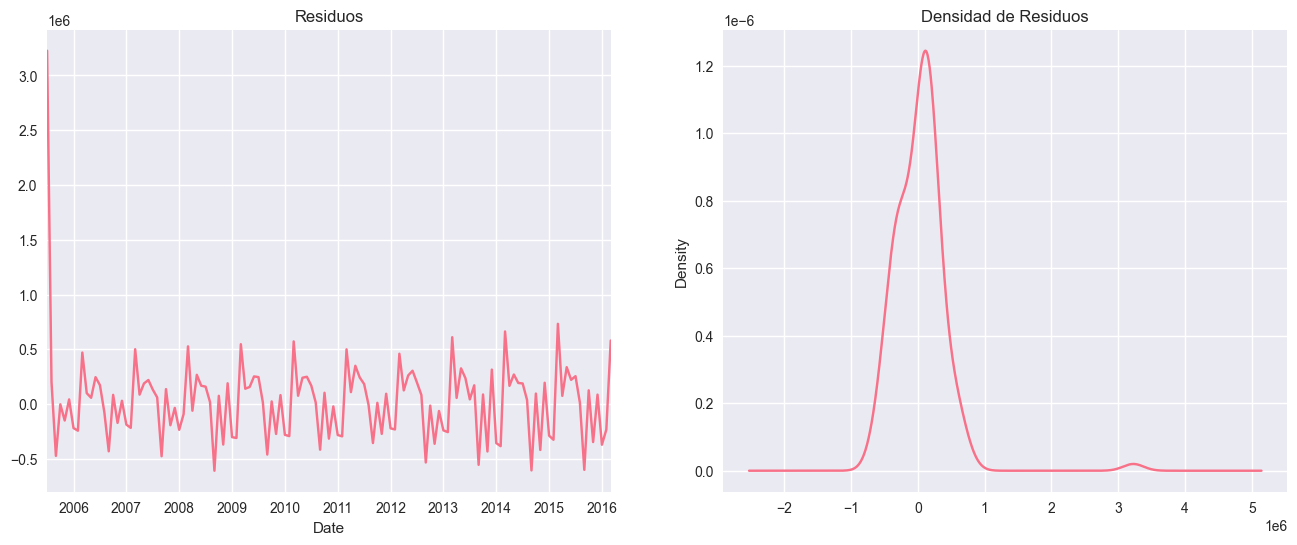

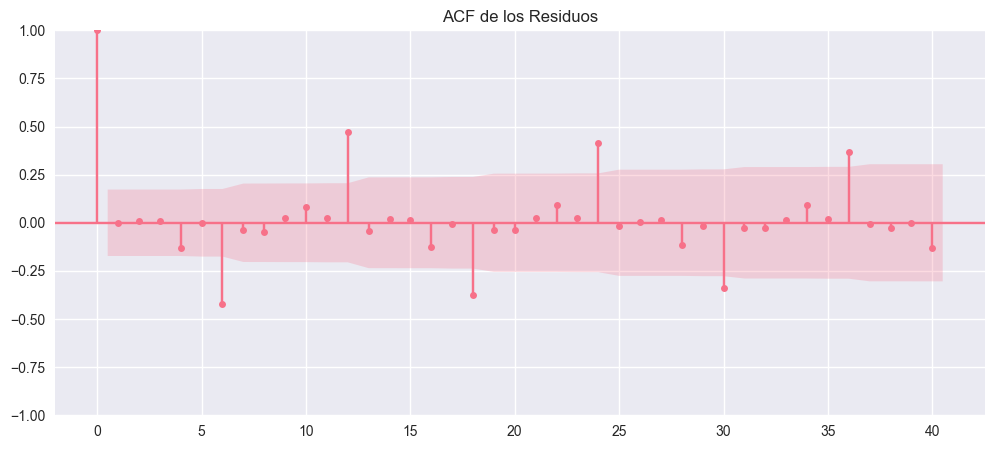

In [12]:
# Gráficos de residuos
residuals = model_fit.resid
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
residuals.plot(title="Residuos", ax=ax[0])
residuals.plot(kind='kde', title="Densidad de Residuos", ax=ax[1])
plt.show()

# ACF de los residuos
fig, ax = plt.subplots(figsize=(12, 5))
plot_acf(residuals, ax=ax, lags=40)
plt.title("ACF de los Residuos")
plt.show()